In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

from sklearn.impute import SimpleImputer # for handling missing variables either categorical or numerical
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline # for making pipleine
from xgboost import XGBRegressor # for modelling
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [3]:
df_train.shape, df_test.shape

((1460, 81), (1459, 80))

# Analyse target(Sales_price)

In [4]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

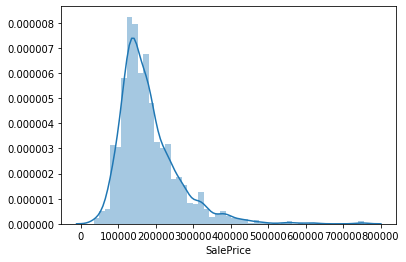

In [5]:
#histogram
sns.distplot(df_train['SalePrice']);

In [6]:
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


#### Positive Skewedness tells us a positively skewed distribution
#### Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.
#### That is, data sets with high kurtosis tend to have heavy tails, or outliers.
#### Data sets with low kurtosis tend to have light tails, or lack of outliers. 

# Correlation matrix (heatmap style).

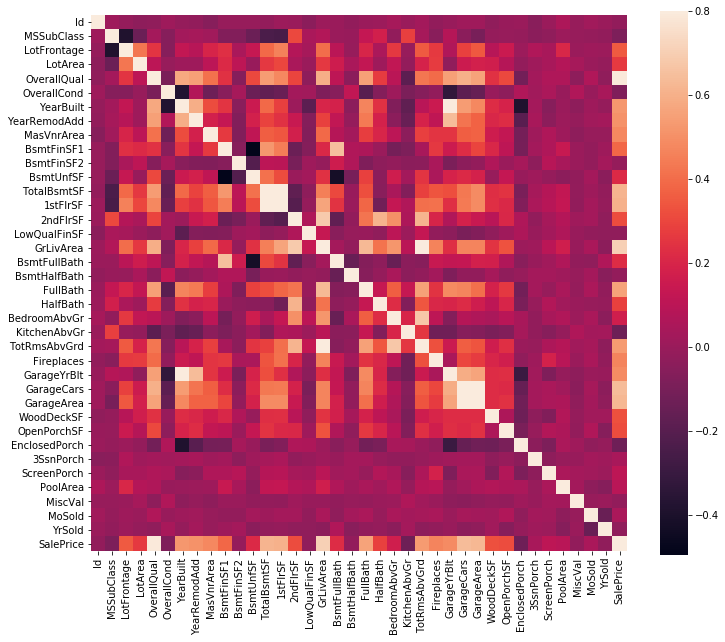

In [7]:
#correlation matrix done on numeric variables only
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrmat, vmax=0.8, square=True)

# 'SalePrice' correlation matrix (zoomed heatmap style)

In [8]:
# #saleprice correlation matrix
# f, ax = plt.subplots(figsize=(10,10))
# k = 10 #number of variables for heatmap
# cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
# cm = np.corrcoef(df_train[cols].values.T)
# sns.set(font_scale=1.25)
# hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10}, yticklabels=cols.values, xticklabels=cols.values)
# plt.show()

#### 'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'. Check!
#### 'GarageCars' and 'GarageArea' are also some of the most strongly correlated variables. However, as we discussed in the last sub-point, the number of cars that fit into the garage is a consequence of the garage area. 'GarageCars' and 'GarageArea' are like twin brothers. You'll never be able to distinguish them. Therefore, we just need one of these variables in our analysis (we can keep 'GarageCars' since its correlation with 'SalePrice' is higher).
#### 'TotalBsmtSF' and '1stFloor' also seem to be twin brothers. We can keep 'TotalBsmtSF' just to say that our first guess was right (re-read 'So... What can we expect?').
#### 'FullBath'?? Really?
#### 'TotRmsAbvGrd' and 'GrLivArea', twin brothers again. Is this dataset from Chernobyl?
#### Ah... 'YearBuilt'... It seems that 'YearBuilt' is slightly correlated with 'SalePrice'. Honestly, it scares me to think about 'YearBuilt' because I start feeling that we should do a little bit of time-series analysis to get this right. I'll leave this as a homework for you.
#### Let's proceed to the scatter plots.

# Scatter plots between 'SalePrice' and correlated variables 

In [9]:
# #scatterplot
# sns.set()
# cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
# sns.pairplot(df_train[cols], height = 2.5)
# plt.show()

# Missing Data

In [10]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# missing_data.head(20)

In [11]:
# Find columns in Test data with missing values
total_test = df_test.isnull().sum().sort_values(ascending=False)
percent_test = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data_test = pd.concat([total_test, percent_test], axis=1, keys=['Total', 'Percent'])
# missing_data_test.head(35)

### Since Test data have more missing values, we will work on test data and then evaluate both train and test data for missing values column by cloumn.

#### More than 15% of the data is missing, we should delete the corresponding variable and pretend it never existed, hence 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage' will be delelted.
#### 'GarageX' - Since the most important information regarding garages is expressed by 'GarageCars' and considering that we are just talking about 5% of missing data, I'll delete the mentioned 'GarageX' variables.
#### 'BsmtX' - The same logic applies to variables 'BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'. 'TotalBsmtSF will give enough information regarding Basement.
#### 'BsmtFullBath', 'BsmtHalfBath' - 'BsmtFullBath' and 'BsmtHalfBath' are strongly corelated, hence we will keep 'BsmtFullBath', delete the missing data, as it has better corelation with sales price. Will delete the vaiable 'BsmtHalfBath'.
#### Regarding 'MasVnrArea' and 'MasVnrType', we can consider that these variables are not essential. Furthermore, they have a strong correlation with 'YearBuilt' and 'OverallQual' which are already considered. Thus, we will not lose information if we delete 'MasVnrArea' and 'MasVnrType'.
#### 'MSZoning', 'Utilities', 'Functional', 'Saletype', 'KitchenQual', 'GarageArea' - This feature looks like will have a good correlation with the salePrice, hence only the missing data will be deleted.
#### 'Exterior1st' and 'Exterior2nd' should have strong correlation and hence we can delete one variable. Will delete  'Exterior2nd'.
#### Finally, we have one missing observation in 'Electrical'. Since it is just one observation, we'll delete this observation and keep the variable.
#### In summary, to handle missing data, we'll delete all the variables with missing data, except the variable 'Electrical'. In 'Electrical' we'll just delete the observation with missing data.

In [12]:
# make a list of all columns with 1 or more than 1 missing values
columns_missing = list(missing_data_test[missing_data_test['Total']>0].index)
# columns_missing

In [13]:
# Make a list of columns that will be dropped from both Test and train dataset
cols_to_del = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'LotFrontage',
       'GarageCond', 'GarageQual', 'GarageYrBlt', 'GarageFinish', 'GarageType',
       'BsmtCond', 'BsmtQual', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtHalfBath',
        'MasVnrType', 'MasVnrArea', 'Exterior2nd', 'BsmtFinSF2',
 'BsmtFinSF1']
# cols_to_del

In [14]:
#Make a list of columns whose missing values rows will be dropped
cols_del_rows = [column for column in columns_missing if column not in cols_to_del]
# cols_del_rows

In [15]:
# Fill missing rows with frequent item in that column
for col in cols_del_rows:
    freq_train = df_train[col].value_counts(ascending=False).index[0]
    df_train[col] = df_train[col].fillna(freq_train)
    
    freq_test = df_test[col].value_counts(ascending=False).index[0]
    df_test[col] = df_test[col].fillna(freq_test)    

In [16]:
freq_train

2

In [17]:
#Delete the columns we decided to delete from both dataset.
for col in cols_to_del:
    df_train = df_train.drop([col], axis=1)
    df_test = df_test.drop([col], axis=1)

In [18]:
# remove the remaining null value left in Train dataset
df_train.dropna(subset = ['Electrical'], inplace=True)
# df_train.isnull().sum()

In [19]:
pd.set_option('display.max_column', None)
df_train.head()

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,ExterQual,ExterCond,Foundation,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageCars,GarageArea,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,Gd,TA,PConc,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,2,1,3,1,Gd,8,Typ,0,2,548,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500
1,2,20,RL,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,TA,TA,CBlock,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,2,0,3,1,TA,6,Typ,1,2,460,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500
2,3,60,RL,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,Gd,TA,PConc,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,2,1,3,1,Gd,6,Typ,1,2,608,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500
3,4,70,RL,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,TA,TA,BrkTil,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,1,0,3,1,Gd,7,Typ,1,3,642,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,5,60,RL,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,Gd,TA,PConc,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,2,1,4,1,Gd,9,Typ,1,3,836,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000


In [20]:
# var = 'SaleCondition'
# total = df_train[var].value_counts()
# percent = df_train[var].value_counts(normalize=True)
# result = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# # result.head(35)

# Analyse columns one by one.


### Categorical value- One hot encoding
MSZoning, Street, LotShape, LandContour, LotConfig, LandSlope, BldgType, RoofStyle, ExterQual, Foundation, KitchenQual, YrSold, MSSubclass, SaleCondition,Condition1

### Delete the columns after further analysis
Utilities- has only one Value count, These columns won’t be useful for the model since they won’t add any information to SalePrice.

Condition2 - Condition1 should give enough info for this feature, so can delete Condition2.

RoofMatl - one Value accounts for more than 90% values. this column wont give any substantial learning to the model.

ExterCond - ExterQual will provide the info needed, so can delete ExterCond.

BsmtUnfSF - TotalBsmtSF will give required info.

Heating, KitchenAbvGr, CentralAir, Electrical, LowQualFinSF, Functional, PavedDrive, 3SsnPorch, ScreenPorch, MiscVal - one Value accounts for more than 90% values. this column wont give any substantial learning to the model.

MoSold - YrSold will be more usefull and representative here, so delete the MoSold column.
 

### Not sure what to do with these
Neighbourhood, 

### Reduce Value Counts and then One Hot encode
HouseStyle, Exterior1st, SaleType, SaleCondition

### Normaise data/Standardise
OverallCond, OverallQual, PoolArea(try scaling as well),BsmtFullBath, FullBath, HalfBath, HalfBath, TotRmsAbvGrd, 
Fireplaces, GarageCars,
LotArea, YearBuilt, YearRemodAdd, 1stFlrSF, 2ndFlrSF, GrLivArea, WoodDeckSF, OpenPorchSF, EnclosedPorch



# Outliers to drop
Not going to use in this exercise as many columns have high range from 0 to thousands, so this approach wont work effectively.

In [21]:
# numerical_cols = [cname for cname in df_train.columns if 
#                 df_train[cname].dtype in ['int64']]
# numerical_cols.remove('SalePrice')

# numerical_cols

In [22]:
# def detect_outliers(df,n,features):
#     """
#     Takes a dataframe of features and returns a list of the indices
#     corresponding to the observations containing more than n outliers according
#     to the Tukey method.
#     """
#     outlier_indices = []
    
#     # iterate over features(columns)
#     for col in features:
#         # 1st quartile (25%)
#         Q1 = np.percentile(df[col], 25)
#         # 3rd quartile (75%)
#         Q3 = np.percentile(df[col],75)
#         # Interquartile range (IQR)
#         IQR = Q3 - Q1
        
#         # outlier step
#         outlier_step = 1.5 * IQR
        
#         # Determine a list of indices of outliers for feature col
#         outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
#         # append the found outlier indices for col to the list of outlier indices 
#         outlier_indices.extend(outlier_list_col)
        
#     # select observations containing more than 2 outliers
#     outlier_indices = Counter(outlier_indices)        
#     multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
#     return multiple_outliers   

# # detect outliers from Age, SibSp , Parch and Fare
# Outliers_to_drop = detect_outliers(df_train,3,numerical_cols)

In [23]:
# pd.set_option('display.max_column', None)
# df_train.loc[Outliers_to_drop]

# Delete the columns as per analyses

In [24]:
columns_delete = ['Utilities', 'Condition2', 'RoofMatl', 'ExterCond', 'BsmtUnfSF',
                  'Heating', 'KitchenAbvGr', 'CentralAir', 'Electrical', 'LowQualFinSF',
                  'Functional', 'PavedDrive', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold']

for col in columns_delete:
    df_train = df_train.drop([col], axis=1)
    df_test = df_test.drop([col], axis=1)

# Reduce Value Counts and then One Hot encode

HouseStyle, Exterior1st,SaleType

### Exterior1st

Reduce the Value_count and then add it to One Hot encode column list

In [25]:
dict = {'VinylSd': 'VinylSd', 'HdBoard': 'HdBoard', 'MetalSd': 'MetalSd', 'Wd Sdng': 'Wd Sdng', 'Plywood': 'Plywood',
       'CemntBd': 'CemntBd',  'BrkFace': 'BrkFace', 'WdShing': 'WdShing', 'Stucco': 'Stucco', 'AsbShng': 'AsbShng',
       'BrkComm': 'Other', 'Stone': 'Other', 'ImStucc': 'Other', 'CBlock': 'Other', 'AsphShn': 'Other'}

# df_train['Exterior1st'] = df_train['Exterior1st'].map(dict)
# df_test['Exterior1st'] = df_test['Exterior1st'].map(dict)

### HouseStyle

Reduce the Value_count and then add it to One Hot encode column list

In [26]:
dict = {'1Story': '1Story', '2Story': '2Story', '1.5Fin': '1.5Fin',
        'SLvl': 'SLvl', 'SFoyer': 'Other', '1.5Unf': 'Other', '2.5Unf': 'Other', '2.5Fin': 'Other'}

# df_train['HouseStyle'] = df_train['HouseStyle'].map(dict)
# df_test['HouseStyle'] = df_test['HouseStyle'].map(dict)

### SaleType

Reduce the Value_count and then add it to One Hot encode column list

In [27]:
dict = {'WD': 'WD', 'New': 'New', 'COD': 'COD', 'ConLD': 'Other', 'CWD': 'Other',
        'Oth': 'Other', 'ConLI': 'Other', 'ConLw': 'Other', 'Con': 'Other'}

# df_train['SaleType'] = df_train['SaleType'].map(dict)
# df_test['SaleType'] = df_test['SaleType'].map(dict)

#  Categorical value- One hot encoding option

In [28]:
cols_to_OH = ['MSZoning', 'Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope',
'BldgType', 'RoofStyle', 'ExterQual', 'Foundation', 'KitchenQual', 'YrSold', 'MSSubClass', 'HouseStyle', 'Exterior1st',
             'SaleType', 'SaleCondition', 'Condition1', 'HeatingQC', 'Neighborhood']

In [29]:
# # Apply one-hot encoder to each column with categorical data
# OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(df_train[cols_to_OH]))
# OH_cols_test = pd.DataFrame(OH_encoder.transform(df_test[cols_to_OH]))

# # One-hot encoding removed index; put it back
# OH_cols_train.index = df_train.index
# OH_cols_test.index = df_test.index

# # Remove categorical columns (will replace with one-hot encoding)
# num_X_train = df_train.drop(cols_to_OH, axis=1)
# num_X_test = df_test.drop(cols_to_OH, axis=1)

# # Add one-hot encoded columns to numerical features
# df_train1 = pd.concat([num_X_train, OH_cols_train], axis=1)
# df_test1 = pd.concat([num_X_test, OH_cols_test], axis=1)
# df_train1.shape

# Categorical value - Get_dummies option

In [30]:
for col in cols_to_OH:
    dummies_train = pd.get_dummies(df_train[col])
    df_train[dummies_train.columns] = dummies_train
    dummies_test = pd.get_dummies(df_train[col])
    df_test[dummies_test.columns] = dummies_test
# Drop categorical columns
df_train1 = df_train.drop(cols_to_OH, axis=1)
df_test1 = df_test.drop(cols_to_OH, axis=1)
df_train1.shape

(1459, 158)

In [31]:
# var = 'LotArea'
# total = df_train[var].value_counts()
# percent = df_train[var].value_counts(normalize=True)
# result = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
# # result.head(35)

# Split the dataset

In [32]:
# spliting training and testing data
from sklearn.model_selection import train_test_split

X = df_train1.drop(['SalePrice', 'Id'], axis=1)
y = df_train1['SalePrice']
X_test = df_test1.drop(['Id'], axis=1).copy()
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2,random_state=27)

# Normalization using sklearn

In [33]:
#  data normalization with sklearn
from sklearn.preprocessing import MinMaxScaler

# fit scaler on training data
norm = MinMaxScaler().fit(X_train)
# norm_X = MinMaxScaler().fit(X)

# transform training data
X_train_norm = norm.transform(X_train)
# X_norm = norm_X.transform(X)

# transform testing dataabs
X_valid_norm = norm.transform(X_valid)

X_test_norm = norm.transform(X_test)


# Standardization using sklearn

In [34]:
# data standardization with  sklearn
from sklearn.preprocessing import StandardScaler

# copy of datasets
X_train_stand = X_train.copy()
X_valid_stand = X_valid.copy()
X_test_stand = X_test.copy()

# numerical features
num_cols = list(df_train1.loc[:,'LotArea':'PoolArea'].columns)

# apply standardization on numerical features
for i in num_cols:
    
    # fit on training data column
    scale = StandardScaler().fit(X_train_stand[[i]])
    
    # transform the training data column
    X_train_stand[i] = scale.transform(X_train_stand[[i]])
    
    # transform the testing data column
    X_valid_stand[i] = scale.transform(X_valid_stand[[i]])
    
    # transform the X_test data columns
    X_test_stand[i] = scale.transform(X_test_stand[[i]])

# K-Nearest Neighbours

In [35]:
# # training a KNN model
# from sklearn.neighbors import KNeighborsRegressor
# # measuring RMSE score
# from sklearn.metrics import mean_squared_error
# from sklearn.metrics import mean_absolute_error

# # knn 
# knn = KNeighborsRegressor(n_neighbors=7)

# rmse = []
# score = []

# # raw, normalized and standardized training and testing data
# trainX = [X_train, X_train_norm, X_train_stand]
# testX = [X_valid, X_valid_norm, X_valid_stand]

# # model fitting and measuring RMSE
# for i in range(len(trainX)):
    
#     # fit
#     knn.fit(trainX[i],y_train)
#     # predict
#     pred = knn.predict(testX[i])
#     # RMSE
#     rmse.append(np.sqrt(mean_squared_error(y_valid,pred)))
#     score.append(mean_absolute_error(y_valid, pred))

# # visualizing the result
# df_knn = pd.DataFrame({'RMSE':score},index=['Original','Normalized','Standardized'])
# df_knn

# RandomForestRegressor

In [36]:
# # training a Decision Tree model
# from sklearn.tree import DecisionTreeRegressor
# # measuring RMSE score
# from sklearn.metrics import mean_squared_error
# 

# # Decision tree
# dt = DecisionTreeRegressor(max_depth=10,random_state=27)

# rmse = []
# score = []

# trainX = [X_train, X_train_norm, X_train_stand]
# testX = [X_valid, X_valid_norm, X_valid_stand]

# # model fitting and measuring RMSE
# for i in range(len(trainX)):
    
#     # fit
#     dt.fit(trainX[i],y_train)
#     # predict
#     pred = dt.predict(testX[i])
#     # RMSE
#     rmse.append(np.sqrt(mean_squared_error(y_valid,pred)))
#     score.append(mean_absolute_error(y_valid, pred))

# # visualizing the result
# df_dt = pd.DataFrame({'RMSE':score},index=['Original','Normalized','Standardized'])
# df_dt

# SVR

In [37]:
# # training an SVR model
# from  sklearn.svm import SVR
# # measuring RMSE score
# from sklearn.metrics import mean_squared_error

# # SVR
# svr = SVR(kernel='rbf',C=5)

# rmse = []
# score = []

# # raw, normalized and standardized training and testing data
# trainX = [X_train, X_train_norm, X_train_stand]
# testX = [X_valid, X_valid_norm, X_valid_stand]

# # model fitting and measuring RMSE
# for i in range(len(trainX)):
    
#     # fit
#     svr.fit(trainX[i],y_train)
#     # predict
#     pred = svr.predict(testX[i])
#     # RMSE
#     rmse.append(np.sqrt(mean_squared_error(y_valid,pred)))
#     score.append(mean_absolute_error(y_valid, pred))

# # visualizing the result
# df_svr = pd.DataFrame({'RMSE':score},index=['Original','Normalized','Standardized'])
# df_svr

# XGBoost

In [38]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=0)

xgb = XGBRegressor(n_estimators=800, learning_rate=0.05, n_jobs=4)

gb_param_grid = {'n_estimators' : [800],
              'learning_rate': [0.05],
              'max_depth': [4] }

xgb_grid = GridSearchCV(xgb, param_grid = gb_param_grid, cv=k_fold, scoring="max_error", n_jobs= 4, verbose = 1)
    
# fit
# xgb_grid.fit(X,y)
xgb_grid.fit(X_train_norm,y_train)

# predict
# pred = xgb_grid.predict(X_valid_norm)
pred = xgb_grid.predict(X_valid_norm)

# print(xgb_grid.best_params_)

rmse = np.sqrt(mean_squared_error(y_valid,pred))
score = mean_absolute_error(y_valid, pred)

rmse, score

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   30.8s finished


(25952.96961477191, 16697.96101776541)

In [39]:
X_valid_norm.shape, X_test.shape, X.shape, X_train_norm.shape

((292, 156), (1459, 156), (1459, 156), (1167, 156))

# Submissions

In [40]:
preds_1 = xgb_grid.predict(X_test_norm)
output = pd.DataFrame({'Id': df_test1['Id'], 'SalePrice': preds_1})
output.to_csv('my_submission_2.csv', index=False)
result = pd.read_csv('my_submission_2.csv')
result.head()

,Id,SalePrice
0,1461,134887.40
1,1462,159603.47
2,1463,176238.45
3,1464,201084.45
4,1465,184839.11


In [41]:
result.shape

(1459, 2)